In [1]:
import pandas as pd
import numpy as np
import logging
from typing import Tuple, List
from hydra.utils import instantiate
from omegaconf import OmegaConf, DictConfig
logger = logging.getLogger(__name__)
import os, sys
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)
from src.data.mimic.semi_synthetic_dataset import MIMIC3SyntheticDataset, load_mimic3_data_raw, \
    SyntheticOutcomeGenerator, SyntheticTreatment

c:\Users\mhr_k\miniconda3\envs\R-learner\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prepare_synthetic_mimic_dataset(args_dataset:DictConfig):
    # save parameters in args
    seed = args_dataset.seed
    path = args_dataset.path
    min_seq_length = args_dataset.min_seq_length
    max_seq_length = args_dataset.max_seq_length
    max_number = args_dataset.max_number
    #load dataset raw
    all_vitals, static_features = load_mimic3_data_raw(path, min_seq_length=min_seq_length,
                                                       max_seq_length=max_seq_length, max_number=max_number,
                                                       data_seed=seed)
    #define the synthetic outcomes and treatments
    #instantiate exog_dependency and the synth_outcome
    exog_dependency = instantiate(args_dataset.synth_outcome.exog_dependency)
    synth_outcome = SyntheticOutcomeGenerator(exogeneous_vars=args_dataset.synth_outcome.exogeneous_vars,
                                                exog_dependency=exog_dependency,
                                                exog_weight=args_dataset.synth_outcome.exog_weight,
                                                endo_dependency=instantiate(args_dataset.synth_outcome.endo_dependency),
                                                endo_rand_weight=args_dataset.synth_outcome.endo_rand_weight,
                                                endo_spline_weight=args_dataset.synth_outcome.endo_spline_weight,
                                                outcome_name=args_dataset.synth_outcome.outcome_name)
    #instantiate the list of synth_treatments
    synth_treatments_list = [instantiate(treatment) for treatment in args_dataset.synth_treatments_list]
    #instantiate the treatment_outcomes_influence
    treatment_outcomes_influence = args_dataset.treatment_outcomes_influence
    #instantiate the MIMIC3SyntheticDataset
    dataset = MIMIC3SyntheticDataset(all_vitals, static_features, 
                                     [synth_outcome], synth_treatments_list,
                                       treatment_outcomes_influence, 'full',
                                       mode = 'factual', projection_horizon = 4,
                                       parallel=args_dataset.parallel)
    return dataset

In [3]:
dataset_config_path = r'C:\Users\mhr_k\OneDrive\Documents\Thesis\Neural-R-Learner\config\dataset\mimic_synthetic.yaml'
args_dataset = OmegaConf.load(dataset_config_path).dataset
dataset = prepare_synthetic_mimic_dataset(args_dataset)

c:\Users\mhr_k\OneDrive\Documents\Thesis\Neural-R-Learner\src\data\mimic\load_data.py:234: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_vitals = all_vitals.fillna(method='ffill')
c:\Users\mhr_k\OneDrive\Documents\Thesis\Neural-R-Learner\src\data\mimic\load_data.py:235: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_vitals = all_vitals.fillna(method='bfill')
  8%|▊         | 8/100 [00:03<00:40,  2.25it/s]

KeyboardInterrupt: 

In [4]:
data = dataset.data
data.keys()

dict_keys(['sequence_lengths', 'prev_treatments', 'vitals', 'next_vitals', 'current_treatments', 'static_features', 'active_entries', 'unscaled_outputs', 'prev_unscaled_outputs'])

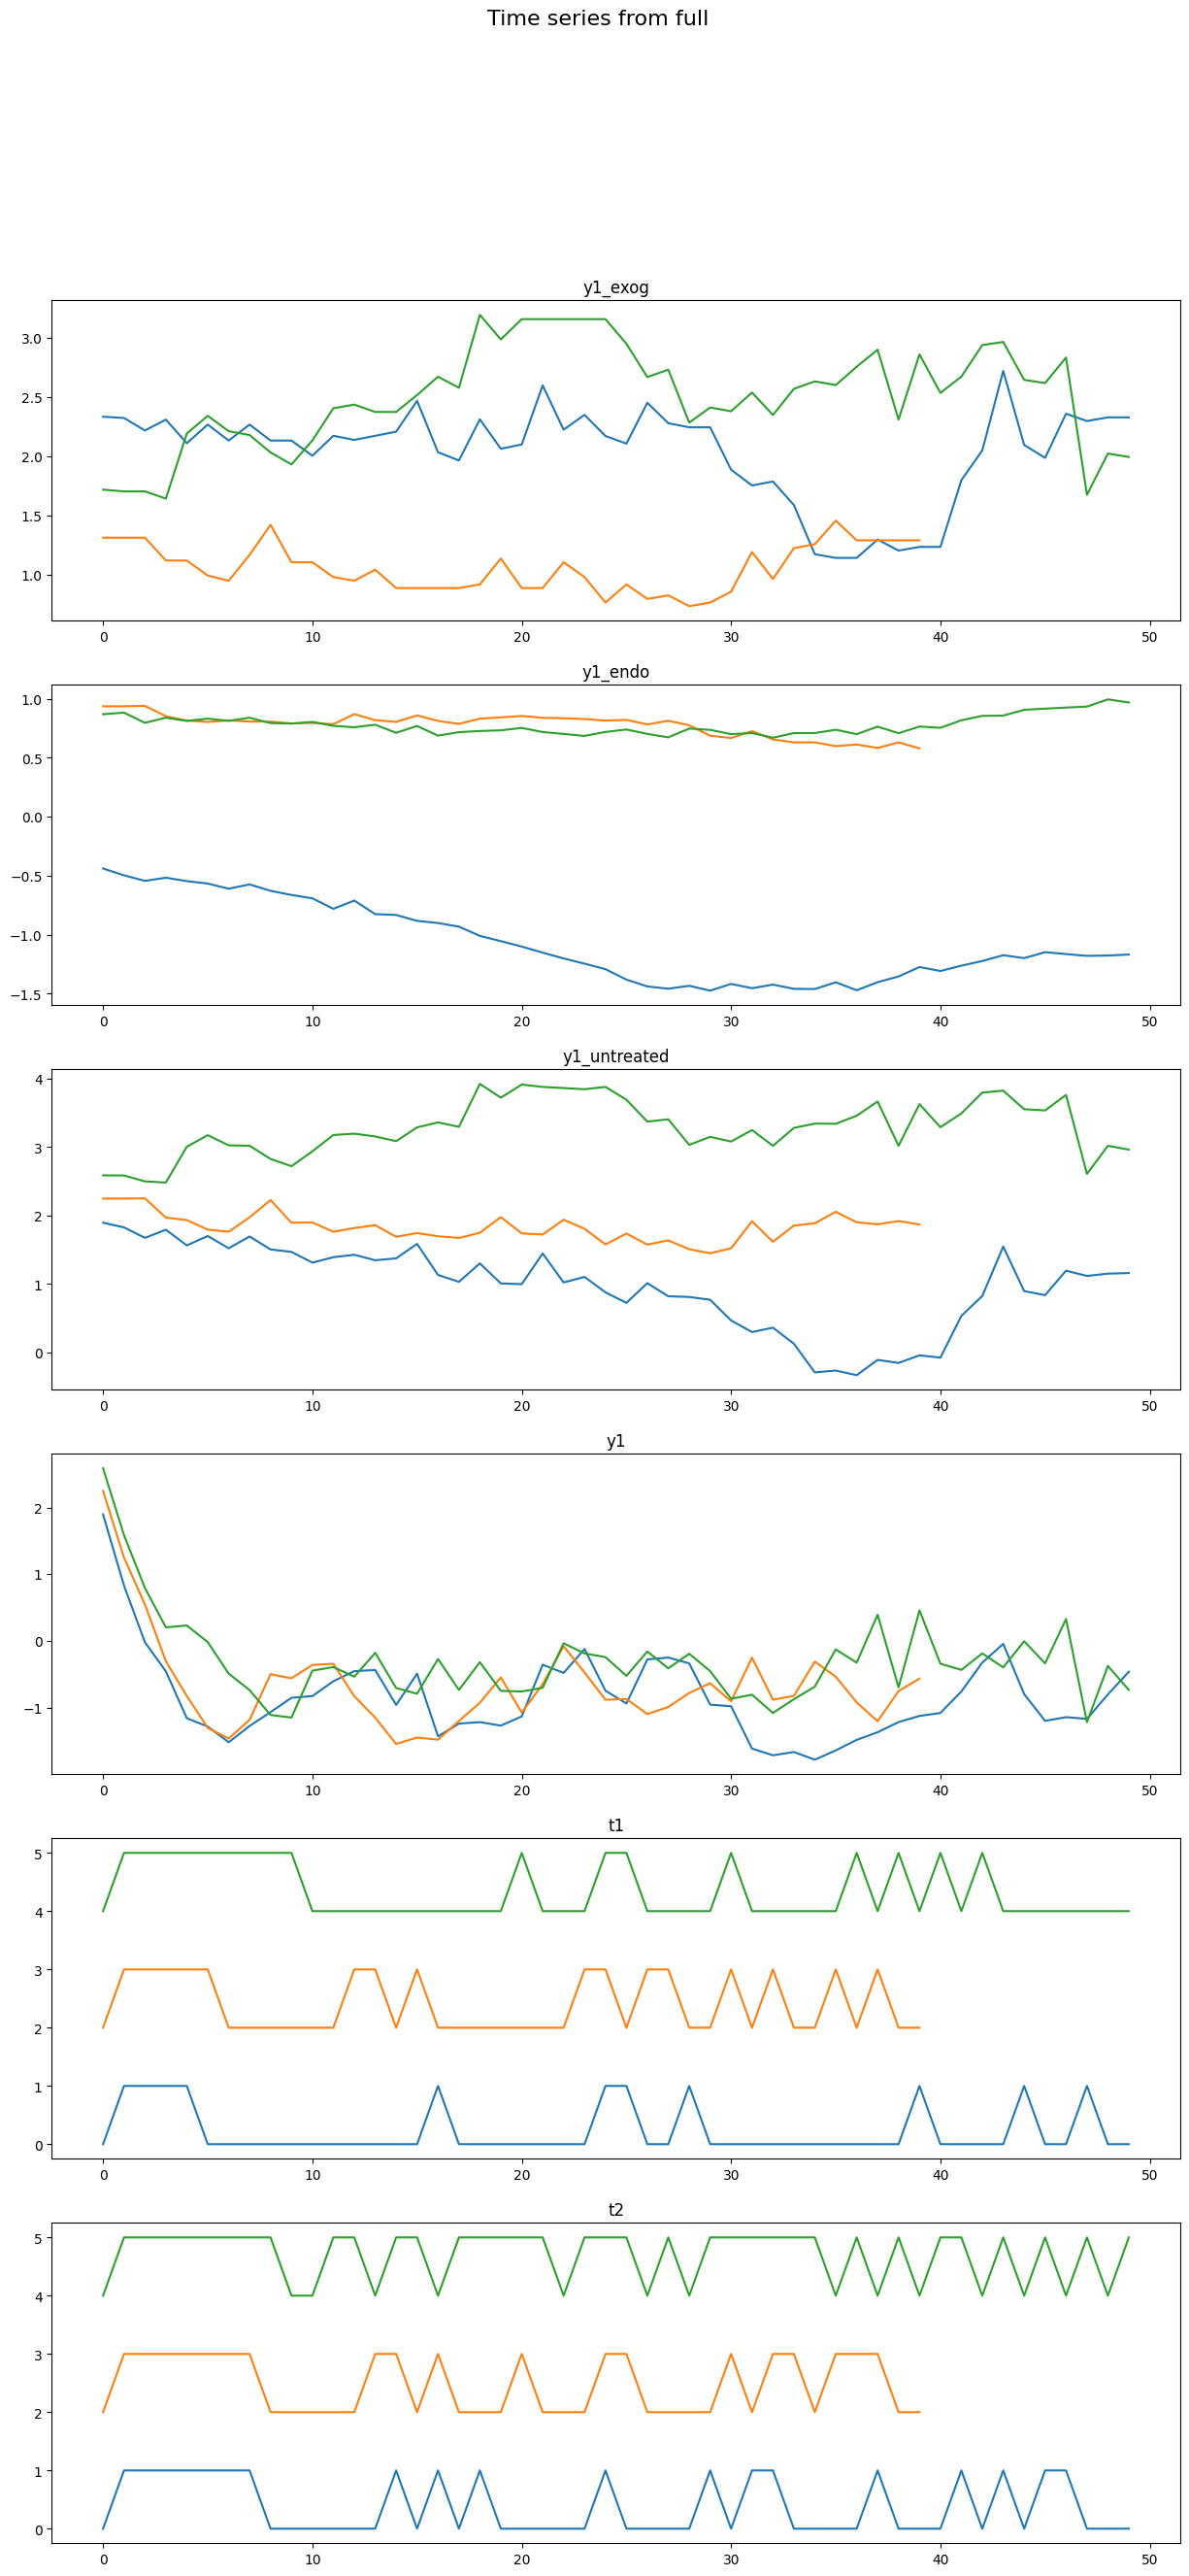

In [5]:
dataset.plot_timeseries(n_patients=3, mode = 'factual')